In [1]:
import torch 
import torch.nn as nn 
import numpy as np
from log_util.logger import Logger
import utils.visualization as vis 

import matplotlib.pyplot as plt 
import seaborn
from envs.nonstationary_env import NonstationaryEnv
import pandas as pd
import seaborn as sns 
import torch.distributions as pyd
from torch.nn import functional as F
import gym 

In [2]:
import json 
import os 
def load_local_config(config_path):
    with open(config_path,'r') as f:
        local_config = json.load(f)
    local_config['device'] = 'cpu'
    local_config['use_wandb'] = False 
    local_config['use_remote'] = False 
    dir,name = os.path.split(config_path)
    new_name = 'local_' + name
    new_file_name = os.path.join(dir,new_name)
    with open(new_file_name,'w') as f:
        ser = json.dumps(local_config)
        f.write(ser)
    return new_file_name


In [3]:
local_toy = load_local_config("configs/toy_config.json")


In [5]:
from algorithms.opt_Trainer import Opt_Trainer
from parameter.optm_Params import Parameters
from envencoder.advanced_encoder.e_encoder import UDP_Encoder
from envencoder.advanced_envencoder.udp_envencoder import UdpEnvencoder
# model =  UDP_Encoder(obs_dim=5,act_dim=2,emb_dim=2,max_env_num=10)



import gym
parameter = Parameters(config_path=local_toy,default_config_path="data/GridWorldPlat-v2-UDPEncoder-CodeTest/logs/parameter.json")
env = gym.make(parameter.env_name)
obs_dim,act_dim,emb_dim = env.observation_space.shape[0],env.action_space.shape[0],parameter.emb_dim
udpenvencoder = UdpEnvencoder(obs_dim=obs_dim,act_dim=act_dim,emb_dim=emb_dim,parameter=parameter)

udpenvencoder.load("data/GridWorldPlat-v2-UDPEncoder-CodeTest")


Defaul config path: data/GridWorldPlat-v2-UDPEncoder-CodeTest/logs/parameter.json
Use additional config
tensor(0)
tensor(20)


In [5]:
state_dict = torch.load("data/GridWorldPlat-v2-UDPEncoder-CodeTest/encoder.pt")

In [6]:
for k,v in state_dict.items():
    print(k,v.shape)

W torch.Size([50, 2, 128])
sigma torch.Size([50])
n_env torch.Size([])
N torch.Size([50])
m torch.Size([50, 2])
e torch.Size([50, 2])
net.0.weight torch.Size([256, 7])
net.0.bias torch.Size([256])
net.2.weight torch.Size([256, 256])
net.2.bias torch.Size([256])
net.4.weight torch.Size([128, 256])
net.4.bias torch.Size([128])


In [8]:
print(state_dict['n_env'])

tensor(20, device='cuda:0')


In [13]:
obs = torch.randn((10,5))
act = torch.randn((10,2))
obs2 =torch.randn((10,5))
rew = torch.randn((10,1))

obs_p = torch.randn((10,10,5))
act_p = torch.randn((10,10,2))
obs2_p =torch.randn((10,10,5))
rew_p = torch.randn((10,10,1))
chosen_embedding,chosen_dist,idx,chosen_mean,distance = udpenvencoder.encoder.inference(obs,act,obs2,rew,id = None)

In [14]:
mode = torch.mode(idx,dim = 0)
print(mode.indices,mode.values)
chosen_embedding = chosen_embedding[mode.indices]
print(chosen_embedding.shape)

torch.Size([1, 2])


# OOD Detection


In [12]:
from envencoder.optimization import MAML

maml = MAML(worker.envcoder.encoder,lr = 0.0001,first_order=True)
transition = worker.envcoder.transition 

## data collection, including OOD and ID
worker.non_stationary = False
list_embs,list_cof,list_real_parameter,trans = worker.raw_emb_collection(100,log_scale=4.0,n_tasks=10)

<AxesSubplot:xlabel='emb_x', ylabel='emb_y'>

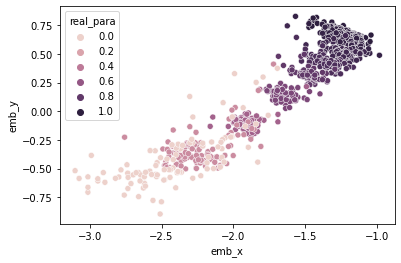

In [5]:
## Raw emb plotting 
raw_df = construct_df(list_embs,list_cof,list_real_parameter)

sns.scatterplot(x = 'emb_x',y = 'emb_y',data = raw_df,hue = 'real_para')

In [6]:

## calc error 
s = trans['s']
a = trans['a']
s2 = trans['s2']
s,a,s2,embs = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float(),torch.from_numpy(list_embs).float()

with torch.no_grad():
    s2_pred ,_ = transition.forward(s,a,embs)
    err = (s2_pred - s2)**2
    err = torch.mean(err,dim = -1).mean(-1).numpy()

print(err)
print(np.argmax(err))



[0.1780523  0.153855   0.3119091  0.2618185  0.44232175 0.7790638
 1.0479702  0.99069977 2.4886367  3.6202934 ]
9


In [17]:
## all burn in 

supprot_x = s[9]
support_a = a[9]
support_x2 = s2[9]

learner = maml.clone()

for _ in range(80):
    emb_to_pred,_ = learner.forward(supprot_x,support_a,support_x2)
    loss ,info = transition._compute_loss(supprot_x,support_a,support_x2,emb_to_pred)
    learner.adapt(loss,first_order=True,allow_unused=True)


In [18]:
# new embs 
s = trans['s']
a = trans['a']
s2 = trans['s2']
s,a,s2 = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float()
new_emb,_ = learner.forward(s,a,s2)
with torch.no_grad():
    s2_pred ,_ = transition.forward(s,a,new_emb)
    err = (s2_pred - s2)**2
    err = torch.mean(err,dim = -1).mean(-1).numpy()


In [19]:
print(err,np.argmax(err))

[ 0.7394162  1.599711   1.2742867  2.0895514  3.392532   3.5988245
  4.9982276  8.782378  13.708336  24.473755 ] 9


# Embedding Analysis

In [ ]:
worker.non_stationary = False
list_embs,list_cof,list_real_parameter,trans = worker.raw_emb_collection(100,log_scale=3.0,n_tasks=50,)

In [6]:
s = trans['s']
a = trans['a']
s2 = trans['s2']
r = trans['r']
list_trans,list_paras = construct_trans(s,a,s2)
s,a,s2,embs = torch.from_numpy(s).float(),torch.from_numpy(a).float(),torch.from_numpy(s2).float(),torch.from_numpy(list_embs).float()
r = torch.from_numpy(r).float()
mean_embs = torch.mean(embs,dim = 1 )

_,logprob = trainer.encoder.transition.forward(s,a,embs,s2)
logprob = logprob.detach().numpy()


In [7]:
n_task = s.shape[0]
trans_matrix = np.zeros(shape=(n_task,n_task))
policy_matrix = np.zeros(shape=(n_task,n_task))
qvalue_matrix = np.zeros(shape = (n_task,n_task))
q_error = np.zeros(shape = (n_task,n_task))

for i in range(n_task):
    mean_emb = mean_embs[i:i+1]
    mean_emb = mean_emb.expand((100,-1))
    for j in range(n_task):
        tmp_s,tmp_a,tmp_s2,tmp_r = s[j],a[j],s2[j],r[j]
        with torch.no_grad():
            _,log_trans_prob =  trainer.encoder.transition.forward(tmp_s,tmp_a,mean_emb,tmp_s2)
            log_policy_prob = trainer.sac.policy.get_prob(tmp_s,tmp_a,mean_emb)
            qvalue = trainer.sac.value1.forward(tmp_s,tmp_a,mean_emb)
            chosen_action = trainer.sac.policy.act(tmp_s2,mean_emb,deterministic=True)
            next_q = trainer.sac.value1.forward(tmp_s2,chosen_action,mean_emb)
            error = torch.abs(next_q + tmp_r - qvalue)
        trans_matrix[i,j] = log_trans_prob.mean().numpy()
        policy_matrix[i,j] = log_policy_prob.mean().numpy()
        qvalue_matrix[i,j] = qvalue.mean().numpy() 
        q_error[i,j] = error.mean().numpy()
    


In [8]:
trans_matrix_df = pd.DataFrame(trans_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
                    
policy_matrix_df = pd.DataFrame(policy_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
qvalue_matrix_df = pd.DataFrame(qvalue_matrix,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])
q_error_matrix_df = pd.DataFrame(q_error,index=[i for i in range(n_task)],
                                columns=[i for i in range(n_task)])

<AxesSubplot:>

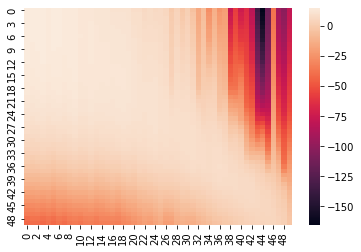

In [9]:
sns.heatmap(trans_matrix_df)

<AxesSubplot:>

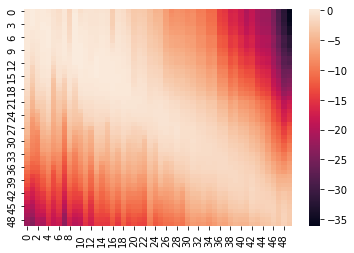

In [10]:
sns.heatmap(policy_matrix_df)

<AxesSubplot:>

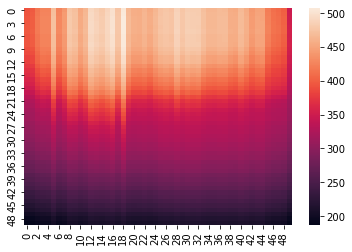

In [11]:
sns.heatmap(qvalue_matrix_df)

<AxesSubplot:>

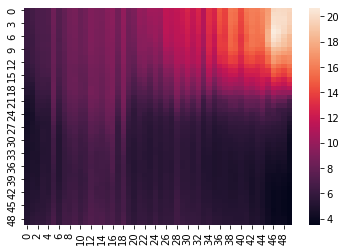

In [12]:
sns.heatmap(q_error_matrix_df)

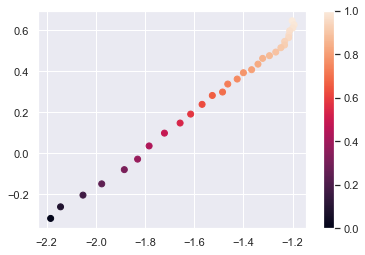

In [51]:
## Parameter 
plt.scatter(mean_embs[:,0],mean_embs[:,1],c = np.mean(list_real_parameter,axis=1)[:,-1])
plt.colorbar()

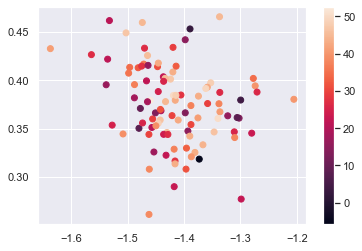

In [37]:
embs_to_plot = embs[2]
logprob_to_plot = logprob[2]
plt.scatter(x = embs_to_plot[:,0],
            y = embs_to_plot[:,1],
            c=logprob_to_plot)
plt.colorbar()
plt.show()

# Detection

In [20]:
embs,change_inds,real_param,logs= worker.ns_test(200,log_scale=7.0,n_tasks=5,ns_sequence=[0,4,1,3,2],ns_period=50)

/Users/jijingtian/opt/anaconda3/envs/meta/lib/python3.7/site-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/Users/jijingtian/Documents/GitHub/RL/Project/Optimization_Encoder/agent/Worker.py:246: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  'G':np.array(Gs),


1. 目的是在两个 change point 中检测正确，包括
   1. 初始化的适应
   2. 第一个 change point 的 detect + estimate 

In [14]:
center_x = 1.2192 + 3.6576 + 6.4008 + 21.9456 + 6.4008
center_y = 4.3180 / 2 

up_x = center_x - 1.8288
up_y = center_y

right_x = center_x
right_y = center_y + 1.8288

down_x = center_x + 1.8288
down_y = center_y 

left_x = center_x
left_y = center_y - 1.8288 

print("Center: ",center_x,center_y)
print("Up: ",up_x,up_y)
print("Right: ",right_x,right_y)
print("Down: ",down_x,down_y)
print("Left: ",left_x,left_y)

Center:  39.623999999999995 2.159
Up:  37.795199999999994 2.159
Right:  39.623999999999995 3.9878
Down:  41.452799999999996 2.159
Left:  39.623999999999995 0.3301999999999998


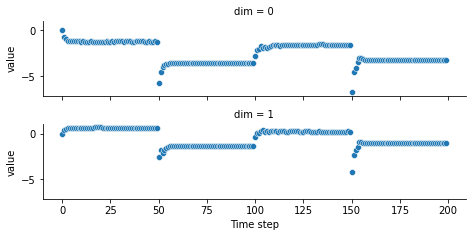

In [21]:
fig = vis.embedding_variation(embs)

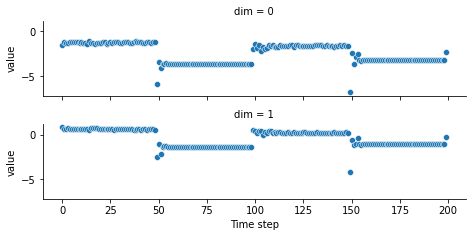

In [22]:
fig = vis.embedding_variation(logs['raw_embs'])

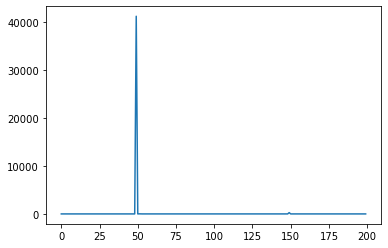

In [23]:
plt.plot(logs['G'])
# plt.plot(logs['s'])
# plt.plot(logs['S'])

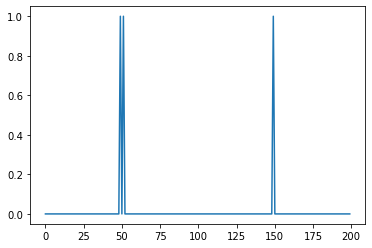

In [24]:
plt.plot(logs['detect_flag'])


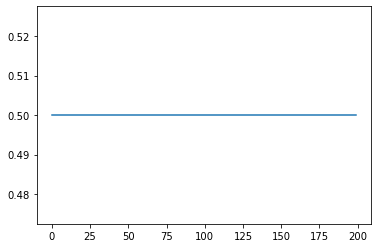

In [12]:
plt.plot(logs['Confidence'])